In [21]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif
import src.utils.sequence as utils

import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
# import wandb # This is optional 
# wandb.login(host = "https://genentech.wandb.io" )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load pre-trained model 

In [22]:
class ModelParameters:
    diffusion_weights_file = 'artifacts/DNA-dataset:v0/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    checkpoint_path = '../../save_models/ATAC_Hepg2_3class_V0/_2024.09.03_04.37.46/diffusion_epoch=000-average-loss=0.92.ckpt'
    time_schedule = 'artifacts/DNA-dataset:v0/time_dependent.npz'
config = ModelParameters() 

DEVICE = "cuda:3"

In [23]:
# Load Reward model
from grelu.lightning import LightningModel

reward_model = LightningModel.load_from_checkpoint("artifacts/model.ckpt")
reward_model.eval()
reward_model.to(DEVICE)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.8
/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/grelu/model/models.py:680: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded 

LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [24]:
# Introduce Two Models

# original_model = lightning_dif.load_from_checkpoint(
#         checkpoint_path=config.checkpoint_path, 
#         weight_file=config.diffusion_weights_file, 
#         time_schedule=config.time_schedule, 
#         all_class_number=3,
#         continuous=False
#     )

original_model = lightning_dif.load_from_checkpoint(
        checkpoint_path=config.checkpoint_path, 
        weight_file=config.diffusion_weights_file, 
        time_schedule=config.time_schedule, 
        augment=False,
        continuous=False,
        all_class_number=3,
    )

original_model = original_model.model
original_model.cuda(device = DEVICE)

/data/yulai/projects/RLfinetuning_Diffusion_Bioseq/tutorials/Human-enhancer/../../src/model/lightning_model_diffusion.py:29: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


AugmentedScoreNet_Conditional(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), 

# Evaluation 

In [29]:
### Get Samples from Pre-Trained Models 

sampler = ddsm.Euler_Maruyama_sampler

strength = 1000

condition_0 = torch.tensor([0,]*128, device=DEVICE, dtype=torch.long)
condition_1 = torch.tensor([1,]*128, device=DEVICE, dtype=torch.long)
condition_2 = torch.tensor([2,]*128, device=DEVICE, dtype=torch.long)

allsamples_original_condition_0 = []
allsamples_original_condition_1 = []
allsamples_original_condition_2 = []

original_model.eval()

for t in range(5):
    samples=[]
    samples.append(sampler(original_model,
                        (200,4),
                        existing_condition = condition_0,
                        class_number = 3,
                        strength = strength, 
                        batch_size = 128,
                        max_time =  4.0,
                        min_time = 1.0/400,
                        time_dilation = 1,
                        num_steps = 100, 
                        eps = 1e-5,
                        speed_balanced = True,
                        device = DEVICE, 
                        augment=False
                        ).cpu().detach().numpy())
    allsamples_original_condition_0.append(samples)

for t in range(5):
    samples=[]
    samples.append(sampler(original_model,
                        (200,4),
                        existing_condition = condition_1,
                        class_number = 3,
                        strength = strength, 
                        batch_size = 128,
                        max_time =  4.0,
                        min_time = 1.0/400,
                        time_dilation = 1,
                        num_steps = 100, 
                        eps = 1e-5,
                        speed_balanced = True,
                        device = DEVICE, 
                        augment=False
                        ).cpu().detach().numpy())
    allsamples_original_condition_1.append(samples)

for t in range(5):
    samples=[]
    samples.append(sampler(original_model,
                        (200,4),
                        existing_condition = condition_2,
                        class_number = 3,
                        strength = strength, 
                        batch_size = 128,
                        max_time =  4.0,
                        min_time = 1.0/400,
                        time_dilation = 1,
                        num_steps = 100, 
                        eps = 1e-5,
                        speed_balanced = True,
                        device = DEVICE, 
                        augment = False
                        ).cpu().detach().numpy())
    allsamples_original_condition_2.append(samples)

In [30]:
allsamples_condition_0 = np.concatenate(allsamples_original_condition_0, axis=1)[0,:,:,:]
allsamples_condition_1 = np.concatenate(allsamples_original_condition_1, axis=1)[0,:,:,:]
allsamples_condition_2 = np.concatenate(allsamples_original_condition_2, axis=1)[0,:,:,:]


In [31]:
allsamples_condition_0.shape
# print(allsamples_condition_0)

(640, 200, 4)

In [32]:
rewards_condition_0 = []
data_loader = torch.utils.data.DataLoader(
        allsamples_condition_0.astype("float32"), 
        batch_size=128 , 
        num_workers=0
    )
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    # batch = (batch < 0.5) * torch.zeros_like(batch)
    
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    rewards_condition_0.append(reward_model(batch).detach().cpu() ) 

rewards_condition_0 = np.concatenate(rewards_condition_0)

In [33]:
rewards_condition_1 = []
data_loader = torch.utils.data.DataLoader(
        allsamples_condition_1.astype("float32"), 
        batch_size=128 , 
        num_workers=0
    )
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    rewards_condition_1.append(reward_model(batch).detach().cpu() ) 

rewards_condition_1 = np.concatenate(rewards_condition_1)

In [34]:
rewards_condition_2 = []
data_loader = torch.utils.data.DataLoader(
        allsamples_condition_2.astype("float32"), 
        batch_size=128 , 
        num_workers=0
    )
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    rewards_condition_2.append(reward_model(batch).detach().cpu() ) 

rewards_condition_2 = np.concatenate(rewards_condition_2)

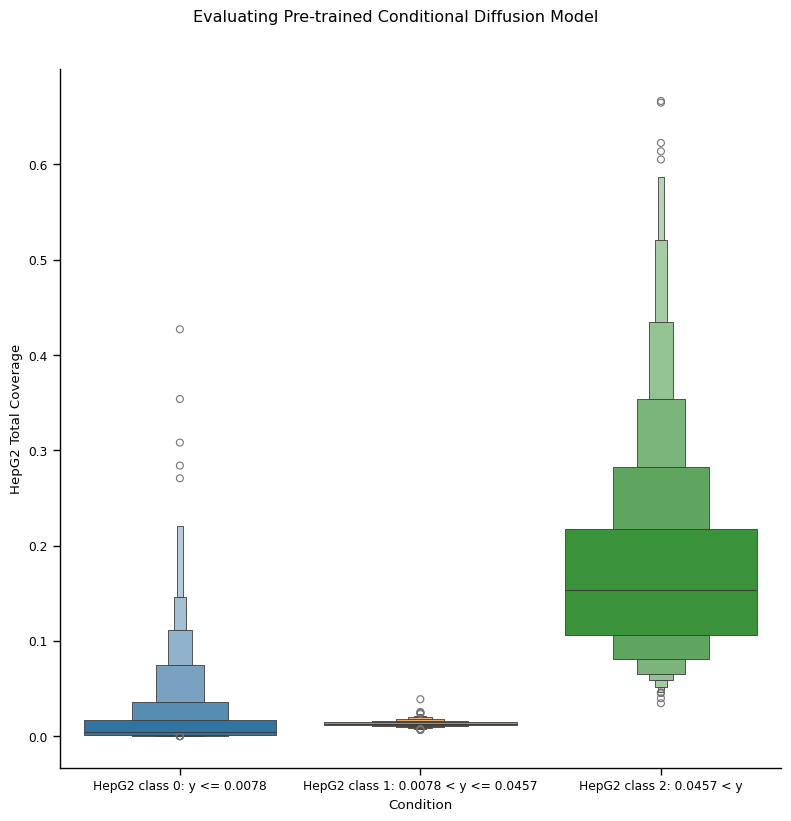

: 

In [36]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

compare = np.concatenate((rewards_condition_0[:,1], 
                          rewards_condition_1[:,1], 
                          rewards_condition_2[:,1]), axis= 0)

type1 = ['HepG2 class 0: y <= 0.0078' for i in range(len(rewards_condition_0[:,1] ))]
type2 = ['HepG2 class 1: 0.0078 < y <= 0.0457' for i in range(len(rewards_condition_1[:,1] ))]
type3 = ['HepG2 class 2: 0.0457 < y' for i in range(len(rewards_condition_2[:,1] ))]

type = type1 + type2 + type3

data_dict = {'Condition': type, 'HepG2 Total Coverage': compare[:,0] }
plot_data = pd.DataFrame(data_dict)

sns.set_context("paper")
fig = sns.catplot(data=plot_data, 
                  x = 'Condition', 
                  y = 'HepG2 Total Coverage', 
                  hue = "Condition", 
                  kind = "boxen", 
                  height = 8, 
                )

# Add title
fig.fig.suptitle('Evaluating Pre-trained Conditional Diffusion Model', y=1.02)

plt.tight_layout()

fig.savefig(f"../../media/Eval_pre-trained-model_strength={strength}_hepg2.png")



